In [1]:
import numpy as np
import torch
import pandas as pd

import matplotlib.pyplot as plt

from collections import namedtuple
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import data_processing as dp
import model
import model_utilities as util
import vocab
import batch_samplers

In [3]:
import IPython


In [4]:
import importlib

In [5]:
importlib.reload(model)

<module 'model' from '/media/itasarom/7158f0d7-af1d-45d4-855f-86204aed5a8b/Projects/diplom/GAN/model.py'>

In [6]:
torch.cuda.is_available()

True

In [7]:
import sklearn
from sklearn.metrics import log_loss, accuracy_score

In [8]:
def build_confusion_matrix(predicted_probs, true_y):
    n_labels = predicted_probs.shape[1]
#     assert true_y.shape == predicted_probs.shape
    result = np.zeros(shape=(n_labels, n_labels))
    
    pred = predicted_probs.argmax(axis=1)
#     true = true_y.argmax(axis=1)
    true = true_y
    
    for pred_cls in range(n_labels):
        for true_cls in range(n_labels):
            result[true_cls, pred_cls] = np.count_nonzero(true[pred == pred_cls] == true_cls)
#     norm = result.sum(axis=1)
#     norm = np.maximum(norm, 1)
#     result /= norm[:, None]
    return result


In [9]:
def get_probs(transformation, model, embeddings, batch_size, use_cuda):
    result = []
#     embed_sum = 0.0
#     squares_sum = 0.0
    embeds = []
    for position in range(0, len(embeddings), batch_size):
        x = embeddings[position:position + batch_size]
        x = torch.autograd.Variable(torch.from_numpy(x)).float()
        if use_cuda:
            x = x.cuda()
        
        x = transformation(x)
        _, probs = model.discriminator.forward(x)
        probs = probs.data.cpu().numpy()
        result.append(probs)
        
        x = x.cpu().data.numpy()
#         embed_sum += x
        embeds.append(x)
        
    return np.vstack(result), np.vstack(embeds)

In [10]:
def validate(model, embeddings_1, embeddings_2, batch_size, use_cuda):
    probs_1, t1 = get_probs(model.transform1, model, embeddings_1, batch_size, use_cuda)
    probs_2, t2 = get_probs(model.transform2, model, embeddings_2, batch_size, use_cuda)
    probs = np.vstack([probs_1, probs_2])
    
    pred_1 = probs_1.argmax(axis=1).reshape(-1, 1)
    pred_2 = probs_2.argmax(axis=1).reshape(-1, 1)    
    pred = np.vstack([pred_1, pred_2])
    
    y_true = np.concatenate([np.zeros((len(pred_1),)), np.ones((len(pred_2)))])
    
    
    acc = accuracy_score(y_pred=pred, y_true=y_true)
    loss = log_loss(y_pred=probs, y_true=y_true)
    cm = build_confusion_matrix(probs, y_true)
    
    plt.hist(probs[:, 1], bins=100, label="1")
    plt.hist(probs[:, 0], bins=100, label="0")
    plt.legend()
    plt.show()
    
    t = np.vstack([t1, t2])
    
    return acc, loss, cm, probs, y_true , t
    

In [18]:
params = {
    'save_path': "./model_checkpoint_2_layers.tc",
    'save_every':10,
    'sentence_iterations':200,
    'discr_iterations':20,
    'transform_iterations':80,
    'n_sents_1':128,
    'n_sents_2':128,
    'n_discr_1':1024,
    'n_discr_2':1024,
    'n_iter':5
    
}

In [12]:
vocab1, all_labels, sents1, labels1 = dp.load_problem(lang='ru')
vocab2, all_labels, sents2, labels2 = dp.load_problem(lang='es')
sent_sampler_1 = batch_samplers.BatchSamplerRegularizer(sents=sents1, labels=labels1, vocab=vocab1, all_labels=all_labels)
sent_sampler_2 = batch_samplers.BatchSamplerRegularizer(sents=sents2, labels=labels2, vocab=vocab2, all_labels=all_labels)
embed_sampler_1 = batch_samplers.BatchSamplerDiscriminator(vocab1)
embed_sampler_2 = batch_samplers.BatchSamplerDiscriminator(vocab2)

In [18]:
cls = model.GAN(100, len(all_labels))
cls = cls.cuda()
trainer = util.Trainer(cls)

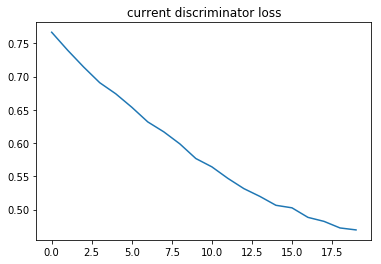

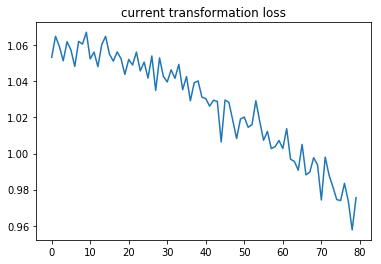

Iter 21 class -1.0, discr0.5872858166694641, transform 1.0264496803283691


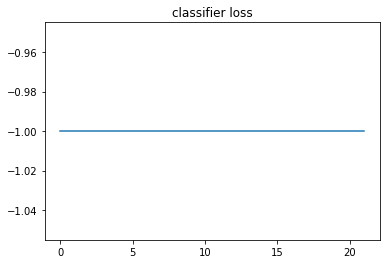

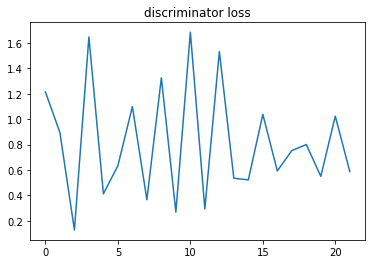

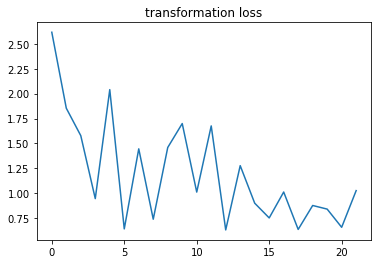

KeyboardInterrupt: 

In [21]:
trainer.train(sent_sampler_1, sent_sampler_2, embed_sampler_1, embed_sampler_2, params)

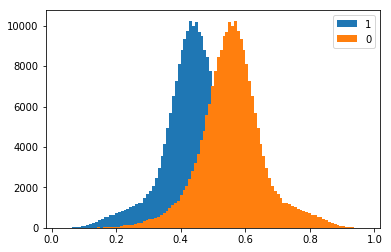

Accuracy  0.7872324406198653
Loss  0.5741456830519649
Confusion matrix
 [[149974.  26058.]
 [ 21983.  27776.]]
Min component variance 7.511720657348633, median component variance 24.216045379638672, mean component variance 28.01129913330078, max c v 95.1778793334961
Total length  225791


In [46]:
cls.eval()
result = validate(cls, vocab1.embeddings, vocab2.embeddings, 200, use_cuda=True)
print("Accuracy ", result[0])
print("Loss ", result[1])
print("Confusion matrix\n", result[2])
vars = result[-1].var(axis=0)
print("Min component variance {}, median component variance {}, mean component variance {}, max c v {}".format(
        min(vars), np.median(vars), np.mean(vars), max(vars)
    ))
print("Total length ", len(result[-1]))

In [13]:
vocab1, all_labels, sents1, labels1 = dp.load_problem(lang='en')
vocab2, all_labels, sents2, labels2 = dp.load_problem(lang='es')
sent_sampler_1 = batch_samplers.BatchSamplerRegularizer(sents=sents1, labels=labels1, vocab=vocab1, all_labels=all_labels)
sent_sampler_2 = batch_samplers.BatchSamplerRegularizer(sents=sents2, labels=labels2, vocab=vocab2, all_labels=all_labels)
embed_sampler_1 = batch_samplers.BatchSamplerDiscriminator(vocab1)
embed_sampler_2 = batch_samplers.BatchSamplerDiscriminator(vocab2)

In [22]:
cls = model.GAN(100, len(all_labels))
cls = cls.cuda()
trainer = util.Trainer(cls)

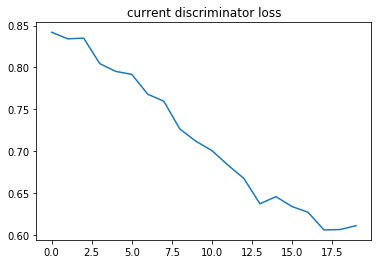

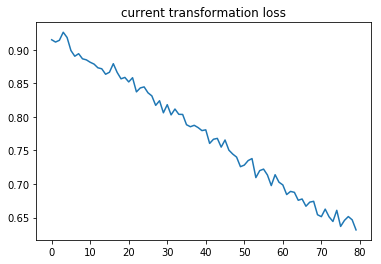

Iter 334 class -1.0, discr0.7143305540084839, transform 0.7756925225257874


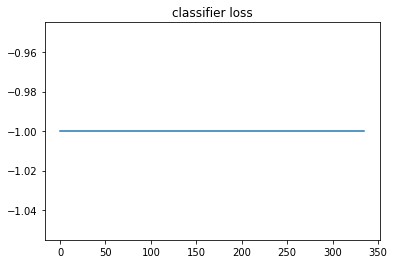

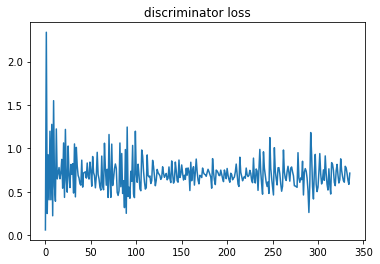

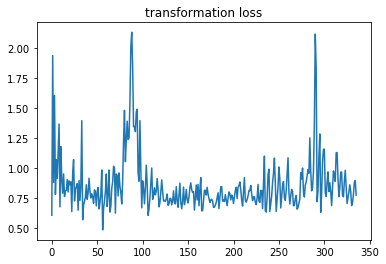

In [64]:
trainer.train(sent_sampler_1, sent_sampler_2, embed_sampler_1, embed_sampler_2, params)

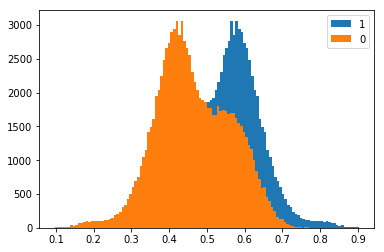

Accuracy  0.1912970986898305
Loss  0.8474211237864785
Confusion matrix
 [[ 1613. 45791.]
 [32785. 16974.]]
Min component variance 5.998392105102539, median component variance 18.64120101928711, mean component variance 21.133302688598633, max c v 47.307769775390625
47404 49759
Total length  97163


In [63]:
cls.eval()
result = validate(cls, vocab1.embeddings, vocab2.embeddings, 200, use_cuda=True)
print("Accuracy ", result[0])
print("Loss ", result[1])
print("Confusion matrix\n", result[2])
vars = result[-1].var(axis=0)
print("Min component variance {}, median component variance {}, mean component variance {}, max c v {}".format(
        min(vars), np.median(vars), np.mean(vars), max(vars)
    ))
print(len(vocab1.embeddings), len(vocab2.embeddings))
print("Total length ", len(result[-1]))

In [14]:
vocab1, all_labels, sents1, labels1 = dp.load_problem(lang='fr')
vocab2, all_labels, sents2, labels2 = dp.load_problem(lang='es')
sent_sampler_1 = batch_samplers.BatchSamplerRegularizer(sents=sents1, labels=labels1, vocab=vocab1, all_labels=all_labels)
sent_sampler_2 = batch_samplers.BatchSamplerRegularizer(sents=sents2, labels=labels2, vocab=vocab2, all_labels=all_labels)
embed_sampler_1 = batch_samplers.BatchSamplerDiscriminator(vocab1)
embed_sampler_2 = batch_samplers.BatchSamplerDiscriminator(vocab2)

In [15]:
cls = model.GAN(100, len(all_labels))
cls = cls.cuda()
trainer = util.Trainer(cls)

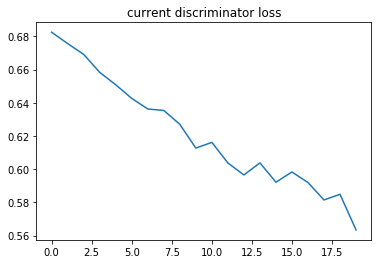

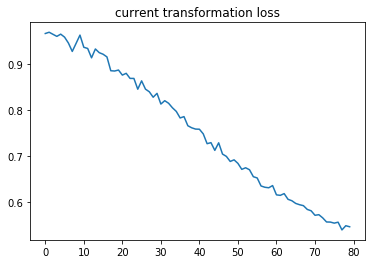

Iter 129 class -1.0, discr0.6211715936660767, transform 0.7555069923400879


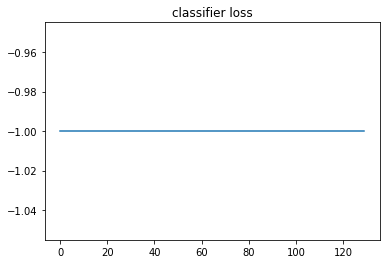

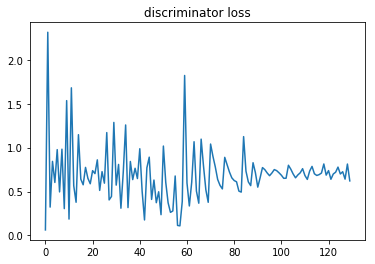

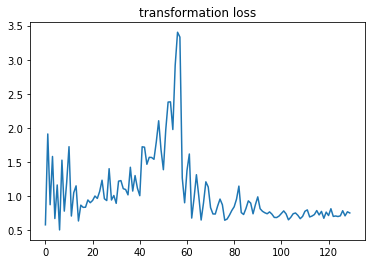

In [21]:

trainer.train(sent_sampler_1, sent_sampler_2, embed_sampler_1, embed_sampler_2, params)

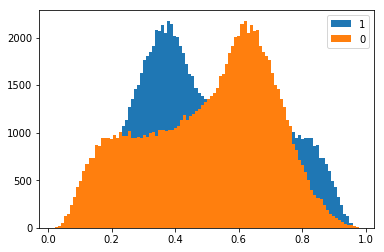

Accuracy  0.21872426288914512
Loss  1.0777029463540937
Confusion matrix
 [[12956. 34421.]
 [41469.  8290.]]
Min component variance 0.5843925476074219, median component variance 4.122730731964111, mean component variance 5.83566951751709, max c v 22.25684356689453
47377 49759
Total length  97136


In [22]:
cls.eval()
result = validate(cls, vocab1.embeddings, vocab2.embeddings, 200, use_cuda=True)
print("Accuracy ", result[0])
print("Loss ", result[1])
print("Confusion matrix\n", result[2])
vars = result[-1].var(axis=0)
print("Min component variance {}, median component variance {}, mean component variance {}, max c v {}".format(
        min(vars), np.median(vars), np.mean(vars), max(vars)
    ))
print(len(vocab1.embeddings), len(vocab2.embeddings))
print("Total length ", len(result[-1]))